In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-07-15 08:09:51.581154: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 08:09:51.581264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 08:09:51.761706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def match_images_with_metadata(image_files, metadata, is_night=False):
    image_data = []
    for img_path in image_files:
        img_name = os.path.basename(img_path)

        if is_night:
            # Night images can be 'villagecode.png' or '2022-villagecode.png'
            # Extract the village code correctly
            if img_name.startswith('2022-'):
                village_code = img_name.split('-')[1].split('.')[0]
            else:
                village_code = img_name.split('.')[0]
        else:
            # Day images can be 'villagecode-l.png', 'villagecode-s.png', '2022-villagecode-l.png', '2022-villagecode-s.png'
            if img_name.startswith('2022-'):
                village_code = img_name.split('-')[1].split('.')[0]
            else:
                village_code = img_name.split('-')[0]

        try:
            # Convert the village code to integer if possible
            village_code = int(village_code)
            village_info = metadata[metadata['KODE BPS'] == village_code]

            if not village_info.empty:
                kecamatan = village_info['KECAMATAN'].values[0]
                desa = village_info['DESA'].values[0]
                status = village_info['BINARY STATUS'].values[0]
                image_data.append({
                    'id': village_code,
                    'filename': img_name,
                    'filepath': img_path,
                    'kecamatan': kecamatan,
                    'desa': desa,
                    'status': status
                })
            else:
                print(f"No matching metadata found for village code: {village_code}")

        except ValueError:
            print(f"Skipping file with unexpected name format: {img_name}")

    return pd.DataFrame(image_data)

In [3]:
def preprocess_metadata(metadata_path):
    idm_df = pd.read_csv(metadata_path)
    idm_df_filtered = idm_df[['KODE BPS', 'KECAMATAN', 'DESA', 'BINARY STATUS']]
    return idm_df_filtered

def normalize_path(path):
    return os.path.normpath(path)

def normalize_paths(df, path_column):
    df[path_column] = df[path_column].apply(normalize_path)
    return df

In [4]:
def count_images_in_folder(folder_path):
    maju_count = len([f for f in os.listdir(os.path.join(folder_path, 'MAJU')) if f.endswith('.png')])
    tertinggal_count = len([f for f in os.listdir(os.path.join(folder_path, 'TERTINGGAL')) if f.endswith('.png')])
    return maju_count, tertinggal_count

def plot_class_distribution_comparison(metadata, ntl_folder):
    # Count class distribution from metadata
    metadata_counts = metadata['BINARY STATUS'].value_counts().sort_index()

    # Map class labels to the actual counts
    metadata_counts_dict = metadata_counts.to_dict()

    # Ensure correct mapping of 'TERTINGGAL' and 'MAJU'
    tertinggal_metadata_count = metadata_counts_dict.get('TERTINGGAL', 0)
    maju_metadata_count = metadata_counts_dict.get('MAJU', 0)

    metadata_values = [tertinggal_metadata_count, maju_metadata_count]

    # Count class distribution from NTL folder
    maju_count, tertinggal_count = count_images_in_folder(ntl_folder)
    ntl_values = [tertinggal_count, maju_count]  # Assuming 'TERTINGGAL' is 0 and 'MAJU' is 1

    # Plot the distributions
    labels = ['TERTINGGAL', 'MAJU']
    x = np.arange(len(labels))

    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    ax1 = axs[0, 0]
    ax3, ax4 = axs[1]
    
    bar_width = 0.35
    opacity = 0.8

    rects1 = ax1.bar(x - bar_width/2, metadata_values, bar_width,
                     alpha=opacity, color='r', label='Before Adding Data')

    rects2 = ax1.bar(x + bar_width/2, ntl_values, bar_width,
                     alpha=opacity, color='b', label='After Adding Data')

    ax1.set_xlabel('Class')
    ax1.set_ylabel('Count')
    ax1.set_title('Comparison of Data Balance Before and After Adding 2022 Data')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.legend()

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax1.annotate(f'{height}', 
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 5), 
                     textcoords='offset points',
                     ha='center', va='bottom', fontsize=10, color='black')

    # Pie charts
    ax3.pie(metadata_values, labels=labels, autopct='%1.1f%%', colors=['r', 'b'])
    ax3.set_title('Class Distribution Before Adding Data')

    ax4.pie(ntl_values, labels=labels, autopct='%1.1f%%', colors=['r', 'b'])
    ax4.set_title('Class Distribution After Adding Data')

    # Hide unused subplot
    axs[0, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

def show_sample_images(day_image_data, night_image_data, class_label, n=5, cols=2):
    # Exclude 2022 images
    day_image_data = day_image_data[~day_image_data['filepath'].str.contains('2022')]
    night_image_data = night_image_data[~night_image_data['filepath'].str.contains('2022')]
    
    # Filter images by class label
    class_images_day = day_image_data[day_image_data['status'] == class_label]
    class_images_night = night_image_data[night_image_data['status'] == class_label]

    # Merge day and night images to find common villages
    common_villages = pd.merge(class_images_day, class_images_night, on='id')
    sample_villages = common_villages.sample(n)

    # Determine the number of rows needed for plotting
    rows = (n // cols) + (n % cols > 0)
    fig, axes = plt.subplots(rows, cols * 2, figsize=(30, 5 * rows))
    fig.patch.set_facecolor('black')
    axes = axes.flatten()

    # Plot day and night images for each sampled village
    for i, (_, village_row) in enumerate(sample_villages.iterrows()):
        # Day images
        img_path_day = village_row['filepath_x']
        img_day = Image.open(img_path_day)
        ax_day = axes[i * 2]
        ax_day.imshow(img_day)
        ax_day.set_title(f"Day - {class_label} - {village_row['kecamatan_x']}_{village_row['desa_x']}", color='white')
        ax_day.axis('off')
        ax_day.set_facecolor('black')

        # Night images
        img_path_night = village_row['filepath_y']
        img_night = Image.open(img_path_night)
        ax_night = axes[i * 2 + 1]  # Correct axis assignment
        ax_night.imshow(img_night)
        ax_night.set_title(f"Night - {class_label} - {village_row['kecamatan_y']}_{village_row['desa_y']}", color='white')
        ax_night.axis('off')
        ax_night.set_facecolor('black')

    # Hide unused subplots
    for ax in axes[len(sample_villages) * 2:]:
        ax.axis('off')
        ax.set_facecolor('black')

    plt.tight_layout()
    plt.show()

In [6]:
def preprocess_image(image_path, target_size=(224, 224)):
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        img = img.resize(target_size)
        img = np.array(img).astype(np.float32) / 255.0
    return img

def load_and_preprocess_data(day_folder, night_folder, target_size=(224, 224)):
    x_day = []
    x_night = []
    y = []

    for class_label, class_folder in enumerate(['TERTINGGAL', 'MAJU']):
        day_class_path = os.path.join(day_folder, class_folder)
        night_class_path = os.path.join(night_folder, class_folder)

        sentinel_images = []
        landsat_images = []
        night_images = []

        for root, _, files in os.walk(day_class_path):
            for file in files:
                if file.endswith('-s.png'):
                    sentinel_images.append(os.path.join(root, file))
                elif file.endswith('-l.png'):
                    landsat_images.append(os.path.join(root, file))
                elif file.startswith('2022') and ('-s.png' in file or '-l.png' in file):
                    sentinel_images.append(os.path.join(root, file))
                    landsat_images.append(os.path.join(root, file))

        for root, _, files in os.walk(night_class_path):
            for file in files:
                if file.endswith('.png'):
                    night_images.append(os.path.join(root, file))
                elif file.startswith('2022') and file.endswith('.png'):
                    night_images.append(os.path.join(root, file))

        night_image_dict = {os.path.basename(img).replace('.png', '').replace('2022-', ''): img for img in night_images}

        for day_image_path in sentinel_images + landsat_images:
            base_name = os.path.basename(day_image_path).replace('-s.png', '').replace('-l.png', '').replace('2022-', '')
            night_image_path = night_image_dict.get(base_name)

            if night_image_path:
                x_day.append(preprocess_image(day_image_path, target_size))
                x_night.append(preprocess_image(night_image_path, target_size))
                y.append(class_label)  # 0 for 'tertinggal', 1 for 'maju'

    x_day = np.array(x_day)
    x_night = np.array(x_night)
    y = np.array(y)

    return x_day, x_night, y

In [7]:
def create_model(input_shape_day=(224, 224, 3), input_shape_night=(224, 224, 3)):
    # Day input branch
    input_day = Input(shape=input_shape_day, name='day_input')
    x1 = Conv2D(32, (3, 3), activation='relu')(input_day)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(64, (3, 3), activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)

    # Night input branch
    input_night = Input(shape=input_shape_night, name='night_input')
    x2 = Conv2D(32, (3, 3), activation='relu')(input_night)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(64, (3, 3), activation='relu')(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Flatten()(x2)

    # Concatenate the outputs of the two branches
    combined = concatenate([x1, x2])

    # Fully connected layers
    x = Dense(128, activation='relu')(combined)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=[input_day, input_night], outputs=output)

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [8]:
def evaluate_model(model, x_day, x_night, y_true, dataset_type="Validation"):
    # Predict the output
    y_pred_prob = model.predict([x_day, x_night])
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"{dataset_type} Data Evaluation")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{dataset_type} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [9]:
def plot_training_history(history):
    # Loss
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
metadata_path = '/kaggle/input/data-au-3/idm_baru.csv'
modified_day_path = '/kaggle/input/data-au-3/Dataset3/Dataset/Daylight'
modified_night_path = '/kaggle/input/data-au-3/Dataset3/Dataset/NTL'

In [11]:
metadata = preprocess_metadata(metadata_path)
day_files = [os.path.join(root, file) for root, _, files in os.walk(modified_day_path) for file in files]
night_files = [os.path.join(root, file) for root, _, files in os.walk(modified_night_path) for file in files]
day_images_metadata = match_images_with_metadata(day_files, metadata)
night_images_metadata = match_images_with_metadata(night_files, metadata, is_night=True)

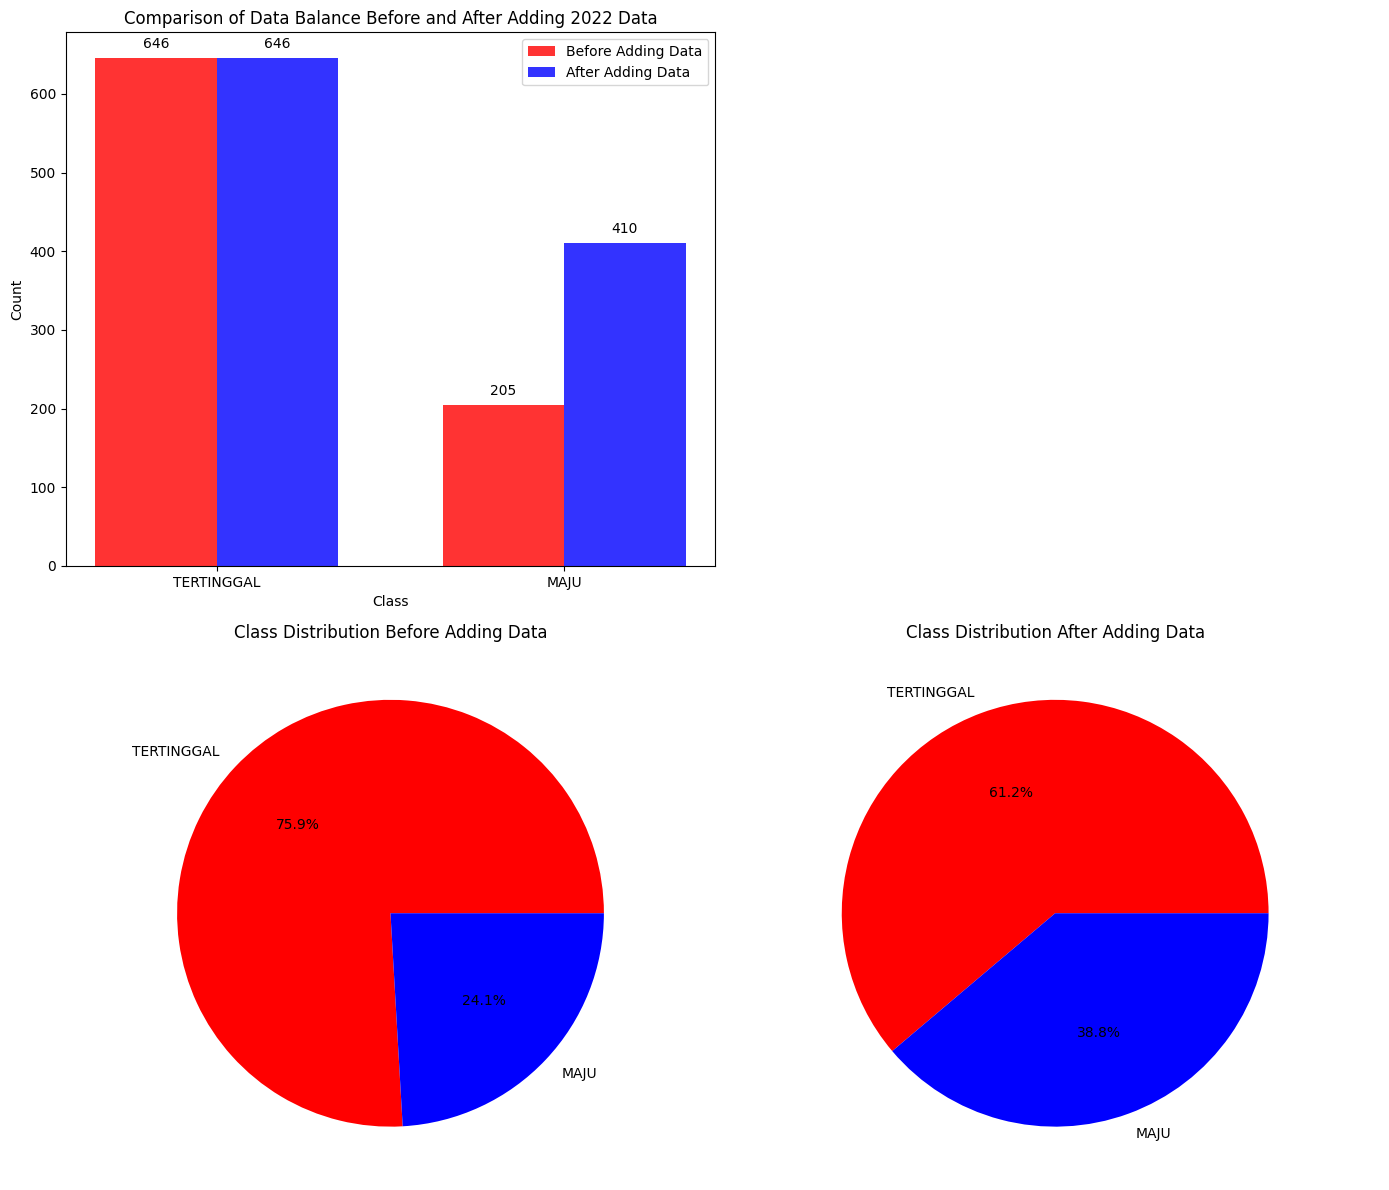

In [12]:
plot_class_distribution_comparison(metadata, modified_night_path)

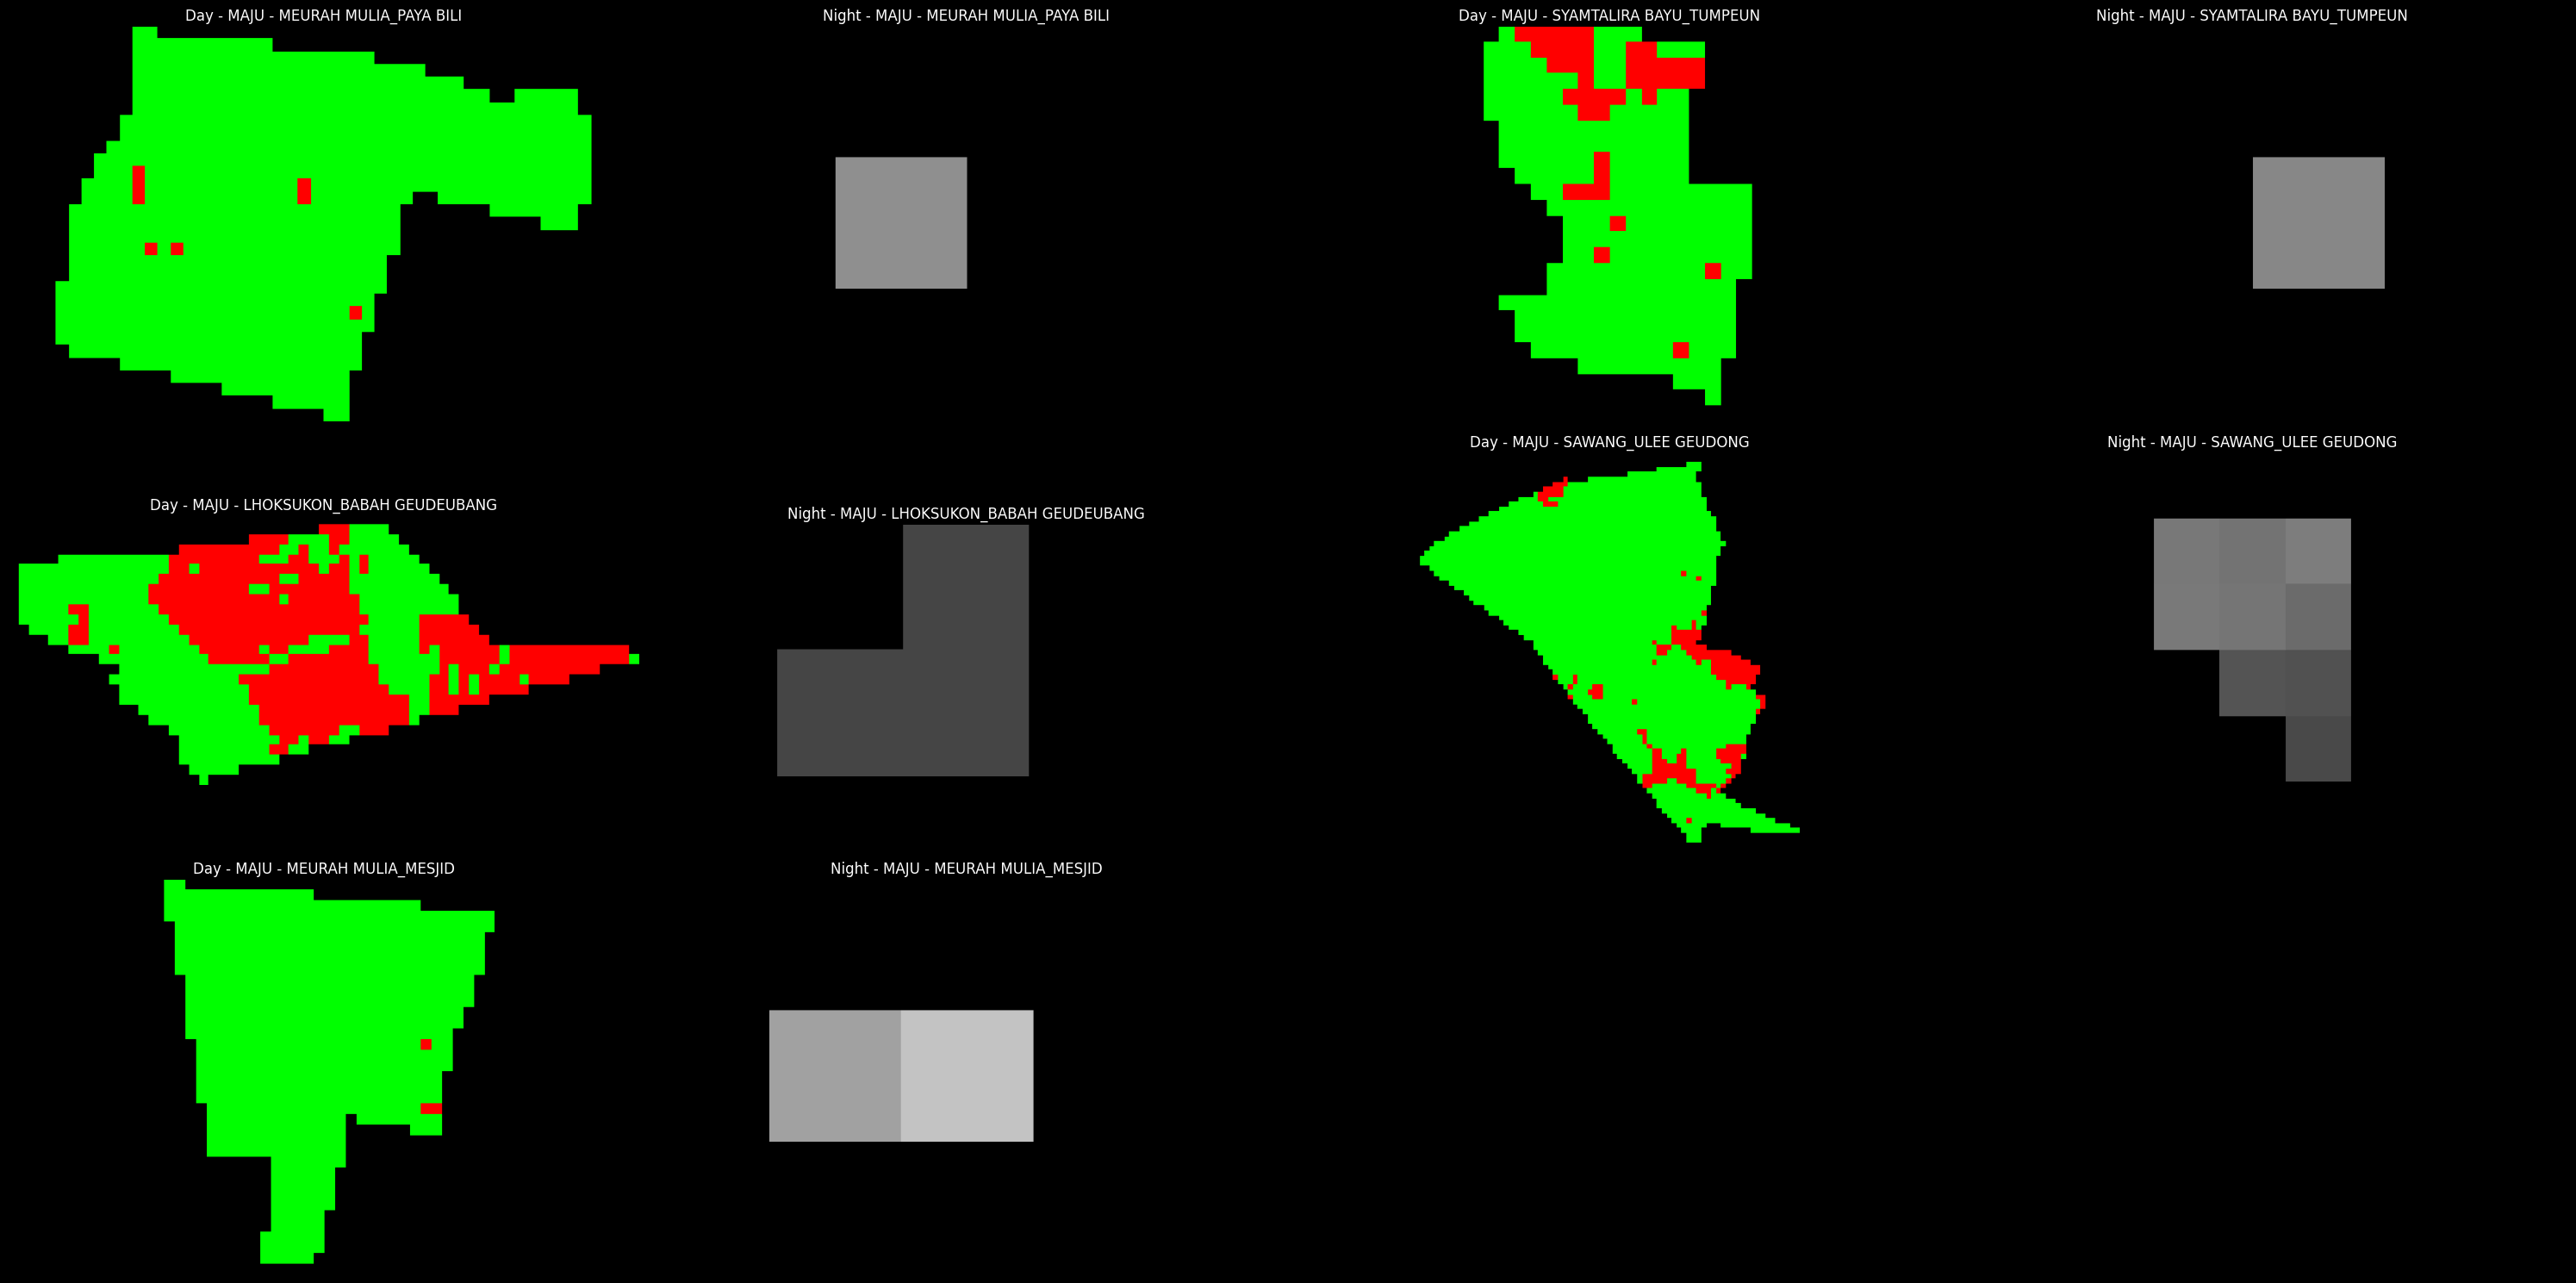

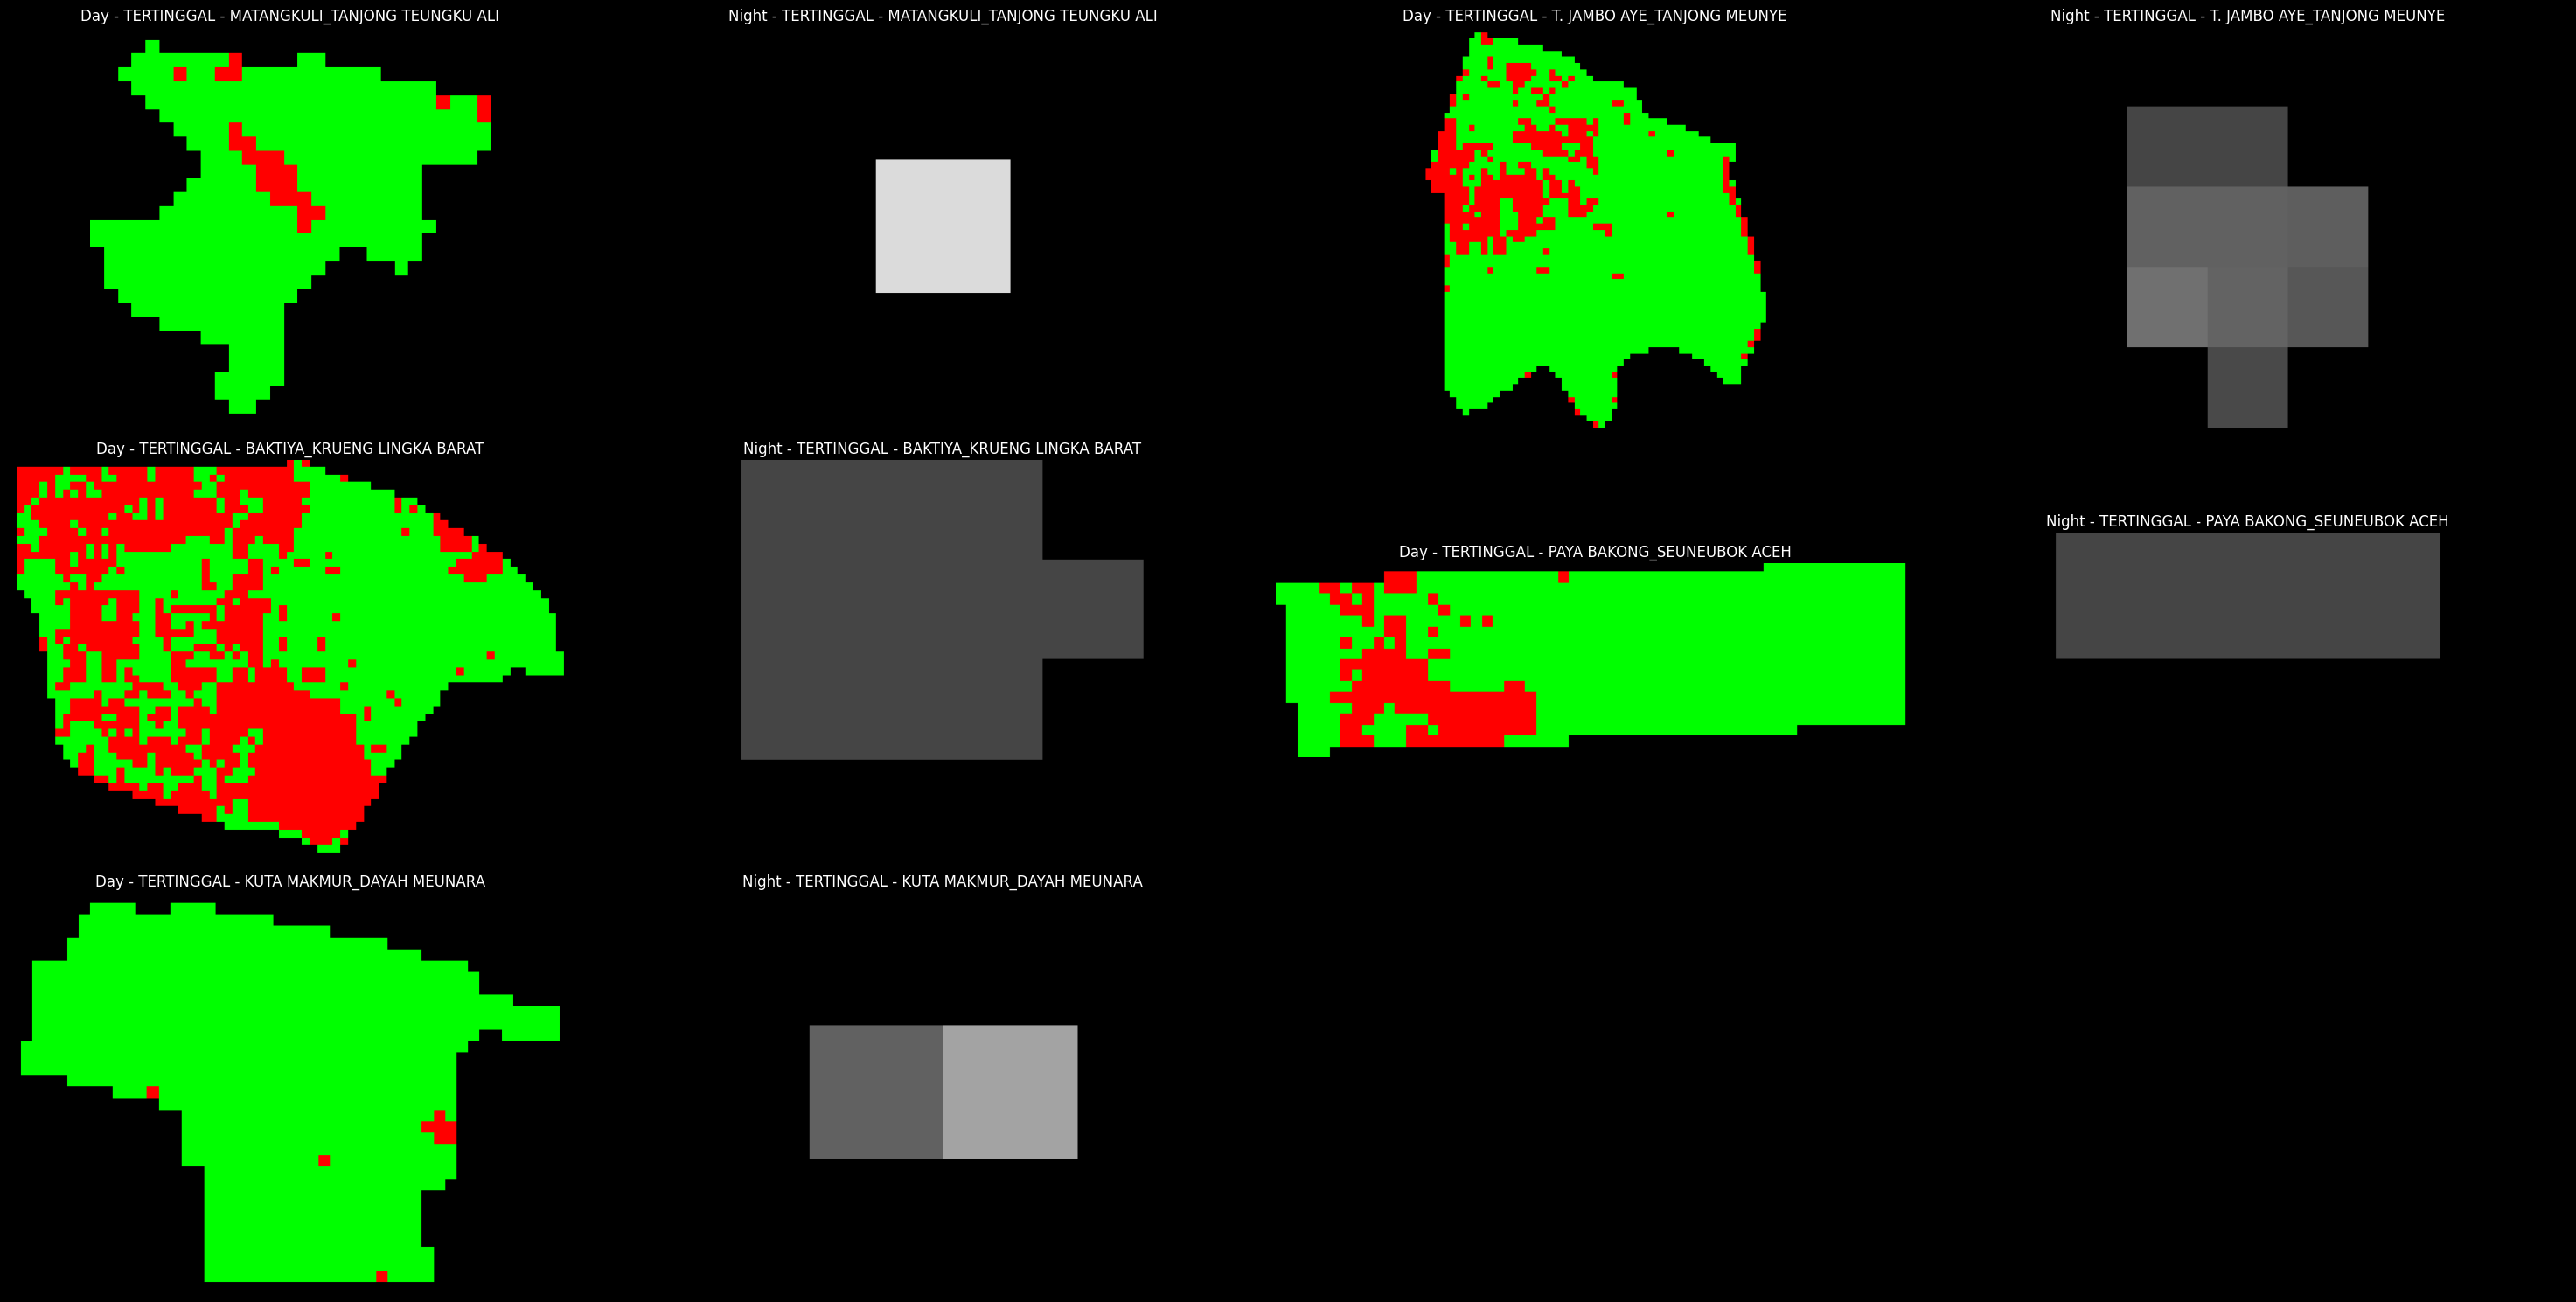

In [13]:
# Visualize data
show_sample_images(day_images_metadata, night_images_metadata, 'MAJU', n=5, cols=2)
show_sample_images(day_images_metadata, night_images_metadata, 'TERTINGGAL', n=5, cols=2)

In [14]:
x_day, x_night, y = load_and_preprocess_data(modified_day_path, modified_night_path)

In [15]:
x_day_train, x_day_val, x_night_train, x_night_val, y_train, y_val = train_test_split(
    x_day, x_night, y, test_size=0.2, random_state=42
)

In [16]:
model = create_model()
model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('status_desa_cnn_best2.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ day_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ night_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        896 │ day_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 222, 222,  │        896 │ night_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 111, 111,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 54, 54,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 186624)    │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 186624)    │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 373248)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 47,775,872 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,822,977 (182.43 MB)

 Trainable params: 47,822,977 (182.43 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    [x_day_train, x_night_train], y_train,
    validation_data=([x_day_val, x_night_val], y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/50
 1/27 ━━━━━━━━━━━━━━━━━━━━ 6:10 14s/step - accuracy: 0.4062 - loss: 0.6988

I0000 00:00:1721031065.785169      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721031065.807264      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.5856 - loss: 1.1646

W0000 00:00:1721031076.272202      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.70686, saving model to status_desa_cnn_best2.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 653ms/step - accuracy: 0.5874 - loss: 1.1526 - val_accuracy: 0.7069 - val_loss: 0.5692
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7618 - loss: 0.4825
Epoch 2: val_accuracy improved from 0.70686 to 0.80378, saving model to status_desa_cnn_best2.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.7627 - loss: 0.4813 - val_accuracy: 0.8038 - val_loss: 0.4176
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9099 - loss: 0.2462
Epoch 3: val_accuracy improved from 0.80378 to 0.87234, saving model to status_desa_cnn_best2.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.9102 - loss: 0.2449 - val_accuracy: 0.8723 - val_loss: 0.3110
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9914 - loss: 0.0551
Epoch 4: val_accuracy improved from 0.87234 to 0.91489, saving model to status_desa_cnn_best

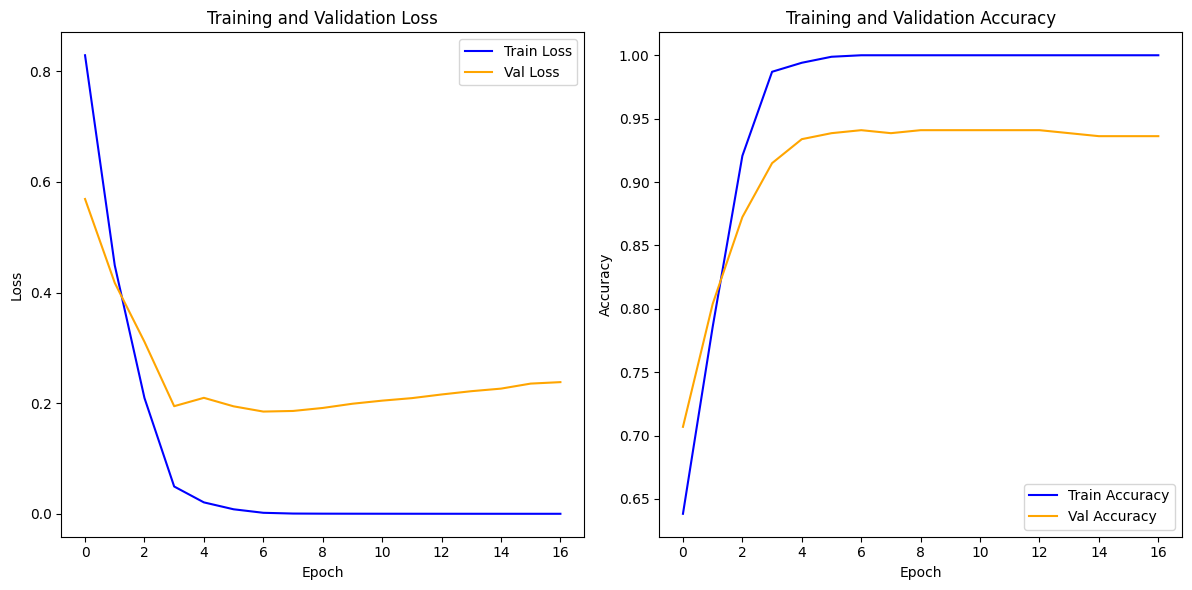

In [18]:
plot_training_history(history)

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
Training Data Evaluation
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1034
           1       1.00      1.00      1.00       655

    accuracy                           1.00      1689
   macro avg       1.00      1.00      1.00      1689
weighted avg       1.00      1.00      1.00      1689



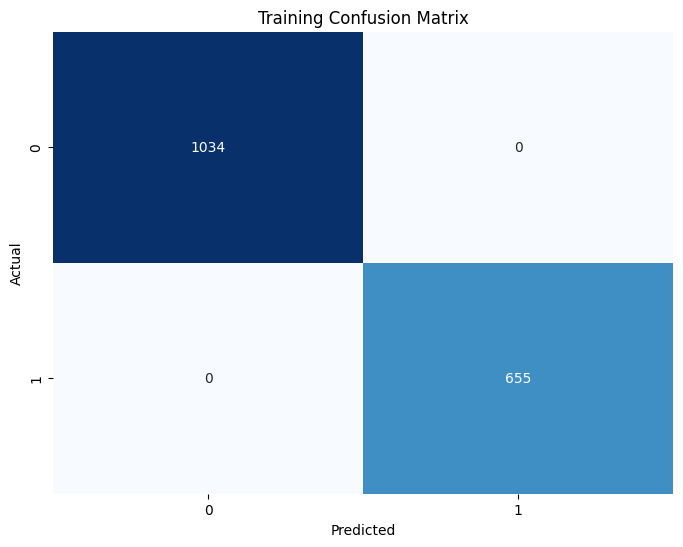

In [19]:
evaluate_model(model, x_day_train, x_night_train, y_train, dataset_type="Training")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Validation Data Evaluation
Accuracy: 0.9409
Precision: 0.9430
Recall: 0.9030
F1 Score: 0.9226

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       258
           1       0.94      0.90      0.92       165

    accuracy                           0.94       423
   macro avg       0.94      0.93      0.94       423
weighted avg       0.94      0.94      0.94       423



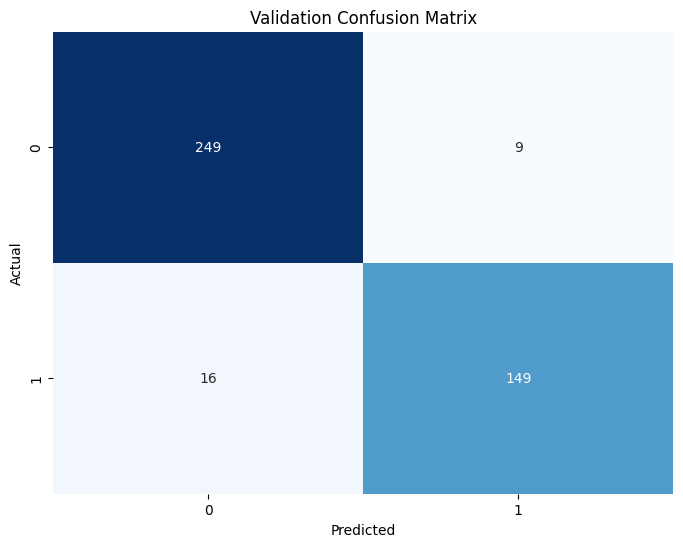

In [20]:
# Evaluate on validation data
evaluate_model(model, x_day_val, x_night_val, y_val, dataset_type="Validation")

In [21]:
model.save('status_desa_cnn3.h5')
print("Model saved successfully.")

Model saved successfully.
